In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import pickle
from tqdm import tqdm
import warnings
import time
import torch
def JSD(P_A, P_B):
    
    epsilon = 1e-8
    P_A = P_A + epsilon
    P_B = P_B + epsilon
    P_merged = 0.5 * (P_A + P_B)
    
    kl_PA_PM = np.sum(P_A * np.log(P_A / P_merged))
    kl_PB_PM = np.sum(P_B * np.log(P_B / P_merged))
    
    jsd = 0.5 * (kl_PA_PM + kl_PB_PM)
    return jsd

# Prepare MoveSim Input

In [5]:
with open('DeepTimeGeo/trained_models/rb_0711_mask_0/data/training_set.pkl', 'rb') as f:
    loc_np, time_x, poi_x, uid, loc_y, loc_y_exploration, is_commuter, rank_dist, selected_home_rank, selected_work_rank = pickle.load(f)
key_table = pd.read_csv('DeepTimeGeo/data/coral_gables/0708_r45_100/coral_gables_dict.csv')[['id', 'lon_x', 'lat_x', 'rank']]

In [6]:
loc_np = np.array(loc_np)
uid_np = np.array(uid)

In [7]:
from tqdm import tqdm
loc_np_filled = loc_np.copy()
for i in tqdm(range(loc_np.shape[0])):
    init = loc_np[i,:][loc_np[i,:] != 0][0]
    for j in range(loc_np.shape[1]):
        if loc_np[i,j] == 0:
            loc_np_filled[i,j] = init
        else:
            init = loc_np[i,j]
            loc_np_filled[i,j] = init


100%|██████████| 34147/34147 [00:04<00:00, 6897.54it/s]


In [8]:
arr_id = np.repeat(uid_np, loc_np_filled.shape[1])
arr_loc = loc_np_filled.flatten()

In [9]:
filled = pd.DataFrame({'id': arr_id, 'rank': arr_loc}, dtype='int64')
merged = pd.merge(filled, key_table, on=['id', 'rank'], how='left')

In [10]:
loc_key = merged[['lon_x', 'lat_x']].drop_duplicates().reset_index(drop=True).reset_index()
final = pd.merge(merged, loc_key, on=['lon_x', 'lat_x'], how='left')

In [11]:
final['lon2'] = final['lon_x'].round(2)
final['lat2'] = final['lat_x'].round(2)
new_loc_index = final.groupby(['lon2', 'lat2']).count().reset_index().reset_index()[['level_0', 'lon2', 'lat2']]
final_d2 = pd.merge(final, new_loc_index, on=['lon2', 'lat2'], how='left')

In [12]:
real_data = final_d2['level_0'].to_numpy().reshape(loc_np_filled.shape)
real_data = real_data.reshape(-1, 24)

In [10]:
X = new_loc_index['lon2'].to_list()
Y = new_loc_index['lat2'].to_list()

In [100]:
np.save('data/ccg/real_data.npy', real_data)
np.save('data/ccg/X.npy', X)
np.save('data/ccg/Y.npy', Y)

In [101]:
loc_den = final_d2.groupby('level_0').count().reset_index()
start = (loc_den['level_0'] / loc_den['level_0'].sum()).to_numpy()
np.save('data/ccg/start.npy', start)

In [31]:
fake_data = real_data.copy()
indices = np.random.choice(real_data.size, int(real_data.size*0.2), replace=False)
random_replacement = np.random.randint(0, len(X), size=indices.size)
fake_data_flat = fake_data.flatten()
fake_data_flat[indices] = random_replacement
fake_data = fake_data_flat.reshape(fake_data.shape)
data_file = 'data/ccg/MoveSim_fake_input.npy'
np.save(data_file, fake_data)

# Evaluate Outputs
## Load Original Data

In [13]:
real_data

array([[1300, 1300, 1300, ..., 1300, 1300, 1300],
       [1300, 1300, 1300, ..., 1300, 1300, 1300],
       [1300, 1300, 1300, ..., 1300, 1300, 1300],
       ...,
       [1573, 1573, 1573, ..., 1380, 1339, 1548],
       [1380, 1380, 1380, ...,  743, 1377, 1377],
       [1377, 1377, 1377, ..., 1344, 1380, 1341]])

In [17]:
dtg = torch.load('DeepTimeGeo/trained_models/rb_0711_s3/simulation/generated_output.pt').cpu().numpy()

## Load Benchmark Results

In [3]:
import sys
sys.path.insert(0, 'MoveSim/code')
from utils import *
movesim = read_data_from_file('MoveSim/data/ccg/gene_epoch_5.data')

In [14]:
seqgan = np.load('SeqGAN_PyTorch/SeqGAN_output.npy')

In [18]:
import importlib
import viz 
importlib.reload(viz)
from viz import viz_stay_duration_dist, viz_departure_time_dist, viz_num_daily_loc_dist
from utils_viz import *

Calculating Stay Duration


100%|██████████| 10000/10000 [00:00<00:00, 11216.78it/s]


Calculating Stay Duration


100%|██████████| 478058/478058 [00:03<00:00, 125355.05it/s]


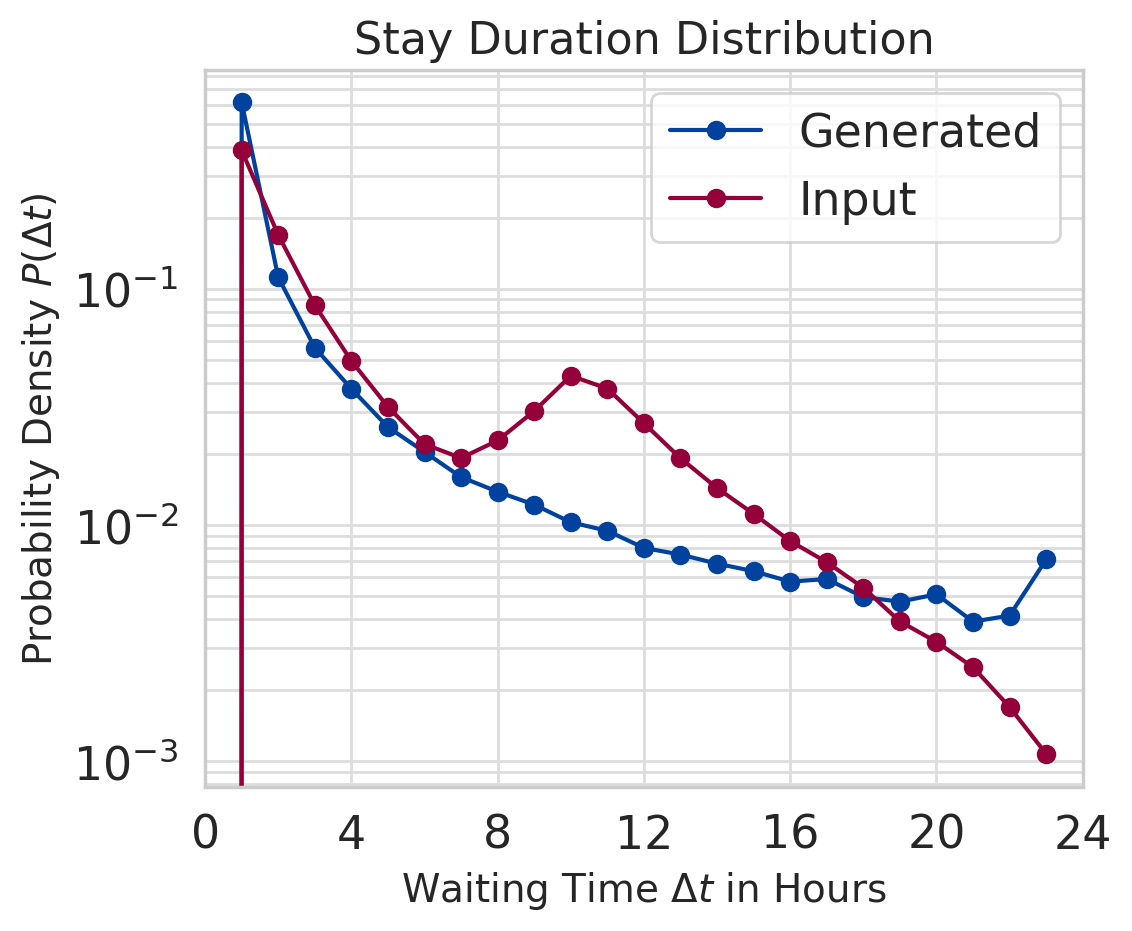

In [20]:
viz_stay_duration_dist(seqgan, real_data, '0712_first_run')

Calculating Departure Time


100%|██████████| 10000/10000 [00:01<00:00, 7284.02it/s]


Calculating Departure Time


100%|██████████| 478058/478058 [00:04<00:00, 102657.66it/s]


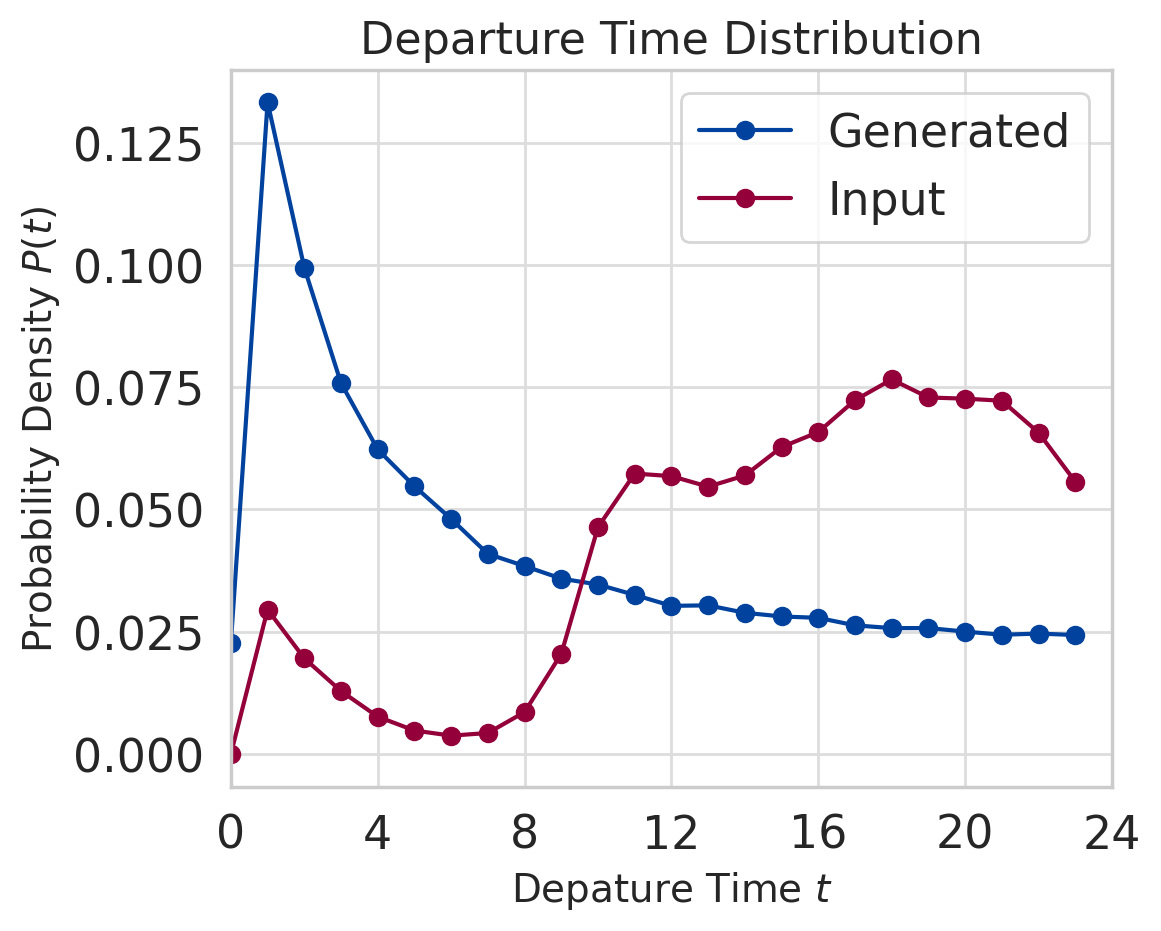

In [72]:
viz_departure_time_dist(generated_data, real_data, '0712_first_run')

Calculating Daily Visited Locations


 15%|█▌        | 21145/140000 [00:00<00:00, 211439.62it/s]

100%|██████████| 140000/140000 [00:00<00:00, 210469.58it/s]


Calculating Daily Visited Locations


100%|██████████| 478058/478058 [00:02<00:00, 230050.50it/s]


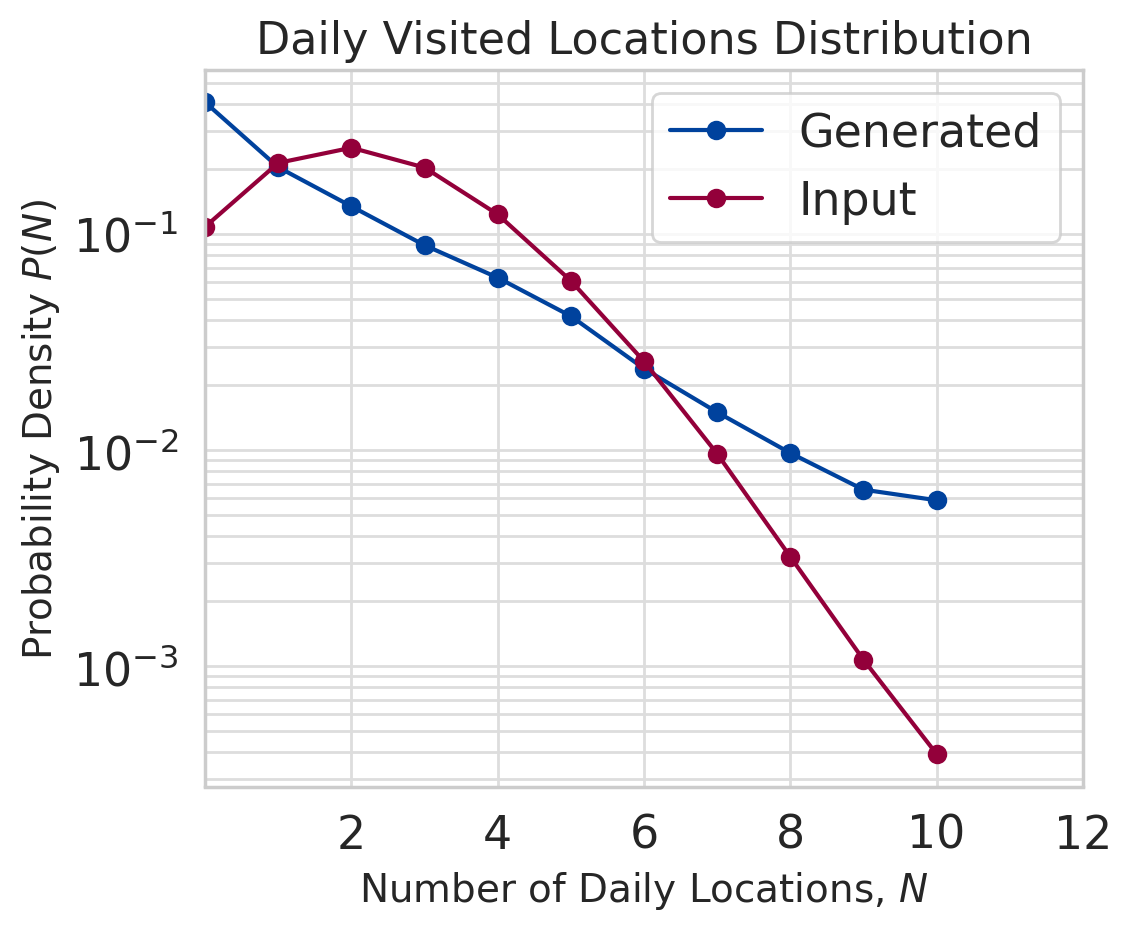

In [73]:
viz_num_daily_loc_dist(generated_data, real_data, '0712_first_run')

In [95]:
gen_pt = get_departure_time(generated_data)
hist, bins = np.histogram(gen_pt, bins=np.arange(0,25,1))
departure_time = hist/hist.sum()

Calculating Departure Time


100%|██████████| 34147/34147 [00:20<00:00, 1654.34it/s]


In [96]:
departure_time

array([0.04224513, 0.01794617, 0.00503572, 0.00037149, 0.0003971 ,
       0.0018684 , 0.00270346, 0.02535416, 0.11525364, 0.01285549,
       0.02750973, 0.04139826, 0.0470823 , 0.04812024, 0.04958721,
       0.05398815, 0.05785415, 0.06137369, 0.06623187, 0.0838992 ,
       0.07914347, 0.06316123, 0.05393002, 0.04268971])

In [97]:
gt_pt = np.array([0.00494407, 0.00253384, 0.00129782, 0.00129782, 0.00568568,
                    0.02064149, 0.05030591, 0.08361659, 0.06501452, 0.04319881,
                    0.04573265, 0.0495643 , 0.06890798, 0.05537359, 0.06044126,
                    0.07403745, 0.07885792, 0.09022928, 0.06927878, 0.04703047,
                    0.03473209, 0.02373154, 0.01563562, 0.00791051])

In [98]:
JSD(departure_time, gt_pt)

0.07712577345043806

In [93]:
gen_pdt = get_stay_duration(generated_data)
hist, bins = np.histogram(gen_pdt, bins=np.arange(0,25,1))
stay_duration = hist/hist.sum()

gt_stay = get_stay_duration(real_data)
hist, bins = np.histogram(gt_stay, bins=np.arange(0,25,1))
gt_pdt = hist/hist.sum()

Calculating Stay Duration


100%|██████████| 34147/34147 [00:02<00:00, 12121.23it/s]


Calculating Stay Duration


100%|██████████| 478058/478058 [00:02<00:00, 188546.86it/s]


In [94]:
JSD(stay_duration, gt_pdt)

0.03845205277022858